In [106]:
#from the py_geospatial environment
import glob
import os
import baseflow #this is the baseflow package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [88]:
#flow data
src = "W:/VUB/_main_research/mHM/model_validation_data/waterinfo_csv/waterinfo_timeseries"

#### Baseflow filter with different methods

In [148]:
datafiles = glob.glob(src + "/*.csv")
#extract the station name
station_names = [os.path.basename(file).split('_')[0] for file in datafiles]

for name, file in zip(station_names, datafiles):
    df = pd.read_csv(datafiles[0], dayfirst=True, index_col=0, parse_dates=True)
    station_name = os.path.basename(file).split('_')[0]
    dfs, bfi = baseflow.separation(df, return_bfi=True)
    print(f'Best Method:\n{df_kge.idxmax(axis=1)}')

100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Best Method:
Q    Slide
dtype: object


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Best Method:
Q    Slide
dtype: object


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Best Method:
Q    Slide
dtype: object


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


Best Method:
Q    Slide
dtype: object


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Best Method:
Q    Slide
dtype: object


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Best Method:
Q    Slide
dtype: object


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Best Method:
Q    Slide
dtype: object


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Best Method:
Q    Slide
dtype: object


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Best Method:
Q    Slide
dtype: object


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Best Method:
Q    Slide
dtype: object


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Best Method:
Q    Slide
dtype: object


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Best Method:
Q    Slide
dtype: object


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

Best Method:
Q    Slide
dtype: object


In [149]:
bfi

,UKIH,Local,Fixed,Slide,LH,Chapman,CM,Boughton,Furey,Eckhardt,EWMA,Willems
Q,0.701854,0.714417,0.739013,0.740925,0.704355,0.493641,0.494045,0.684911,0.667782,0.68481,0.693678,0.678561


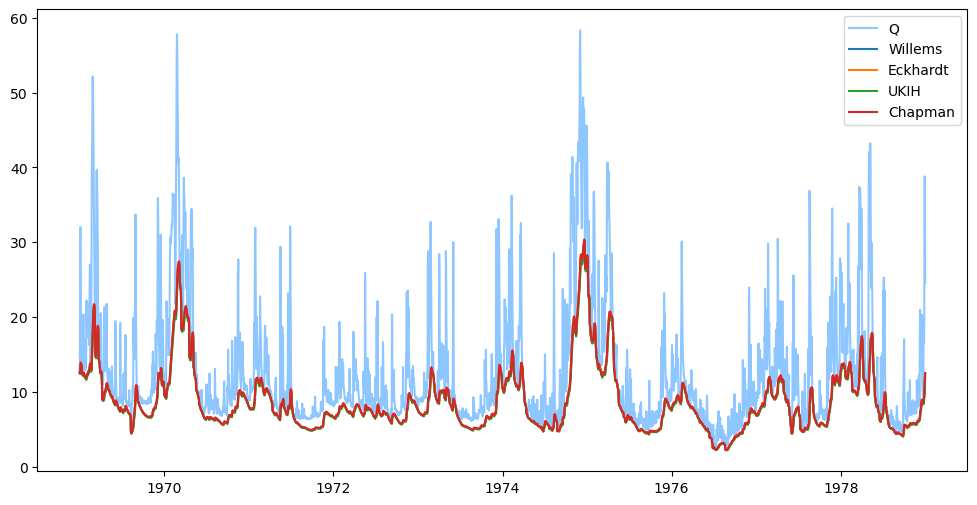

In [144]:
fig,ax = plt.subplots(figsize=(12, 6))
#plot the hydrograph
min_date = df.index.min()
max_date = '1979-01-01'


plt.plot(df['Q'][min_date:max_date], label='Q', c='dodgerblue', alpha=0.5)

#plot the baseflow
plt.plot(dfs['Willems'][min_date:max_date], label='Willems')
plt.plot(dfs['Eckhardt'][min_date:max_date], label='Eckhardt')
plt.plot(dfs['Furey'][min_date:max_date], label='UKIH')
plt.plot(dfs['Boughton'][min_date:max_date], label='Chapman')

#plt.ylim(0, 70)
plt.legend()